In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import MobileBertTokenizer, MobileBertForSequenceClassification, AdamW

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Veri setini yükleme
data = pd.read_csv('0206_veriler.csv')

# Veri setini inceleme
print(data.head())
print(data.describe())

# Veri setini eğitim ve test kümelerine ayırma
X = data['Twitler']
y = data['Durum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                                             Twitler  Durum
0  a101 6 nisan firsatlari\n\nucuzkenaldim \n\nre...      1
1                                         trendyol        1
2                            alisverislerime devam        1
3  kargolarimi bana ulastirmak icin defalarca ara...      1
4              favorilerimin hepsini almak isterdim       1
            Durum
count  386.000000
mean     0.500000
std      0.500649
min      0.000000
25%      0.000000
50%      0.500000
75%      1.000000
max      1.000000


In [3]:
# MobileBERT tokenizer'ını oluşturma
tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased', do_lower_case=True)

In [4]:
# Veri setini tokenleme
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [5]:
# PyTorch tensörlerine dönüştürme
train_inputs = torch.tensor(train_encodings['input_ids'])
train_labels = torch.tensor(list(y_train))
train_masks = torch.tensor(train_encodings['attention_mask'])
test_inputs = torch.tensor(test_encodings['input_ids'])
test_labels = torch.tensor(list(y_test))
test_masks = torch.tensor(test_encodings['attention_mask'])

In [6]:
# GPU kullanımı için tensörleri taşıma
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
train_masks = train_masks.to(device)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)
test_masks = test_masks.to(device)


In [7]:
# MobileBERT modelini yükleme
model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=2)
model.to(device)


Some weights of the model checkpoint at google/mobilebert-uncased were not used when initializing MobileBertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MobileBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some 

MobileBertForSequenceClassification(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_fe

In [8]:
# Optimizer ve öğrenme oranını belirleme
optimizer = AdamW(model.parameters(), lr=1e-5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
import time

# Eğitim döngüsü
model.train()

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []

for epoch in range(10):
    optimizer.zero_grad()
    start_time = time.time()
    outputs = model(input_ids=train_inputs, attention_mask=train_masks, labels=train_labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    end_time = time.time()
    epoch_time = end_time - start_time

    # Eğitim ve test verileri üzerinde loss değerlerini ve doğruluk değerlerini hesaplama
    train_loss_values.append(loss.item())
    model.eval()
    with torch.no_grad():
        start_time = time.time()
        train_outputs = model(input_ids=train_inputs, attention_mask=train_masks)
        train_logits = train_outputs.logits
        train_predictions = torch.argmax(train_logits, dim=1)
        train_accuracy = accuracy_score(list(train_labels.cpu()), list(train_predictions.cpu()))
        train_accuracy_values.append(train_accuracy)

        test_outputs = model(input_ids=test_inputs, attention_mask=test_masks)
        test_logits = test_outputs.logits
        test_predictions = torch.argmax(test_logits, dim=1)
        test_accuracy = accuracy_score(list(test_labels.cpu()), list(test_predictions.cpu()))
        test_accuracy_values.append(test_accuracy)
        end_time = time.time()
        test_time = end_time - start_time
    
    model.train()

    # Epoch numarasını, loss değerini ve süreleri yazdırma
    print("Epoch:", epoch+1, "Loss:", loss.item(), "Train Time:", epoch_time, "Test Time:", test_time)

Epoch: 1 Loss: 1465209.75 Train Time: 41.711511850357056 Test Time: 7.1952738761901855
Epoch: 2 Loss: 1318217.75 Train Time: 40.61799097061157 Test Time: 7.054066896438599
Epoch: 3 Loss: 1160635.75 Train Time: 39.8877170085907 Test Time: 7.391276121139526
Epoch: 4 Loss: 1039689.875 Train Time: 40.54897403717041 Test Time: 7.458959102630615
Epoch: 5 Loss: 922621.625 Train Time: 46.42796492576599 Test Time: 7.756704092025757
Epoch: 6 Loss: 800701.125 Train Time: 47.83516216278076 Test Time: 8.527400970458984
Epoch: 7 Loss: 689374.5625 Train Time: 43.58752417564392 Test Time: 7.89876914024353
Epoch: 8 Loss: 581185.6875 Train Time: 45.62755513191223 Test Time: 7.899069786071777
Epoch: 9 Loss: 491854.125 Train Time: 43.56404709815979 Test Time: 7.2418999671936035
Epoch: 10 Loss: 416605.96875 Train Time: 41.826844930648804 Test Time: 7.377382040023804


In [12]:
# Değerlendirme metriklerini hesaplama
predictions = torch.argmax(test_logits, dim=1)
accuracy = accuracy_score(list(test_labels.cpu()), list(predictions.cpu()))
precision = precision_score(list(test_labels.cpu()), list(predictions.cpu()))
recall = recall_score(list(test_labels.cpu()), list(predictions.cpu()))
f1 = f1_score(list(test_labels.cpu()), list(predictions.cpu()))

# Değerlendirme metriklerini hesaplama
predictions = torch.argmax(test_logits, dim=1)
accuracy = accuracy_score(list(test_labels.cpu()), list(predictions.cpu()))
precision = precision_score(list(test_labels.cpu()), list(predictions.cpu()))
recall = recall_score(list(test_labels.cpu()), list(predictions.cpu()))
f1 = f1_score(list(test_labels.cpu()), list(predictions.cpu()))

# Sonuçları yazdırma
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.6282051282051282
Precision: 0.6282051282051282
Recall: 1.0
F1-Score: 0.7716535433070866


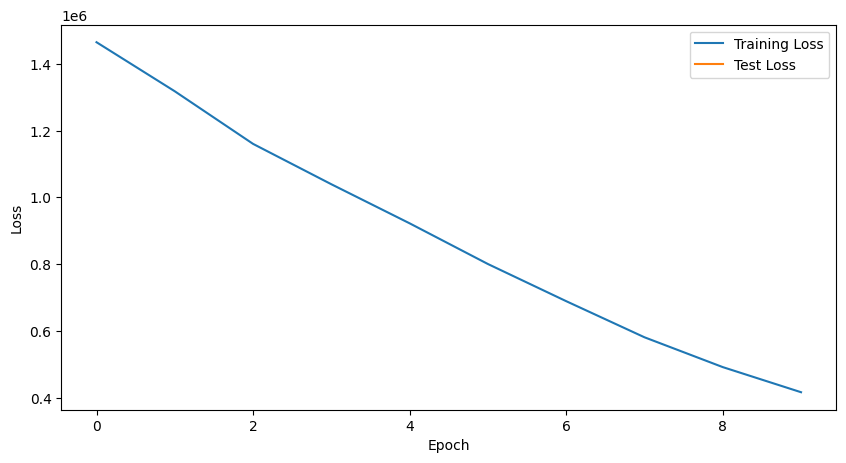

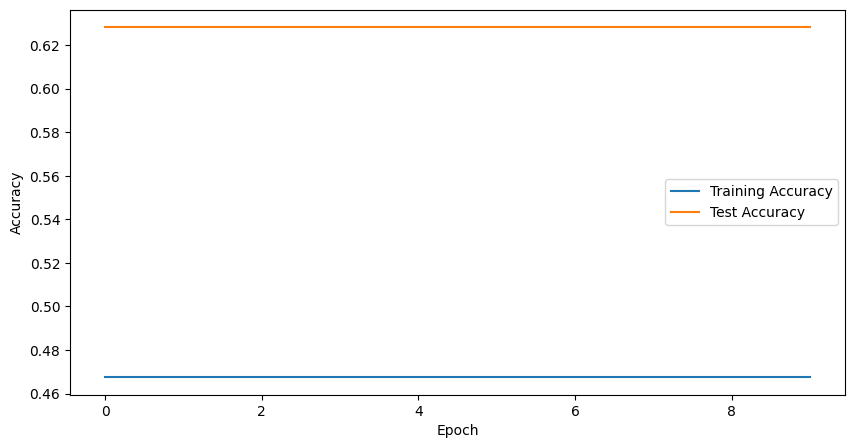

In [14]:
import matplotlib.pyplot as plt

# Eğitim ve test loss değerlerini ve doğruluk değerlerini grafiğe dökme
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(test_loss_values, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_values, label='Training Accuracy')
plt.plot(test_accuracy_values, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()